![](images/2025-02-18-diffusion-model-mnist-part3.png)

## Introduction

Welcome back to the final part of our hands-on journey into diffusion models for MNIST digit generation! In [Part 1](https://hassaanbinaslam.github.io/posts/2025-02-10-diffusion-model-mnist-part1.html), we laid the groundwork by building a basic Convolutional UNet and training it to directly predict clean MNIST digits from noisy inputs. We then enhanced our UNet architecture in [Part 2](https://hassaanbinaslam.github.io/posts/2025-02-15-diffusion-model-mnist-part2.html), leveraging the power of the diffusers library and its UNet2DModel to achieve improved denoising performance.

While our direct image prediction approach showed promising results, we hinted that it was a simplification of true diffusion models. We observed that even with our enhanced UNet and iterative refinement, the generated digits still lacked the crispness and fidelity we might expect from "diffusion model magic."

Now, in this final installment, we're ready to take the leap into the heart of diffusion models. We'll move beyond directly predicting clean images and embrace the core principles that make diffusion models so powerful: **noise prediction** and **scheduled denoising**. Get ready to unlock the true potential of diffusion and witness a significant step-up in image generation quality!

### Credits

This post is inspired by the [Hugging Face Diffusion Course](https://huggingface.co/learn/diffusion-course/en/unit1/3)

### Environment Details

You can access and run this Jupyter Notebook from the GitHub repository on this link [2025-02-18-diffusion-model-mnist-part3.ipynb](https://github.com/hassaanbinaslam/myblog/blob/main/posts/2025-02-18-diffusion-model-mnist-part3.ipynb)

Run the following cell to install the required packages.

* This notebook can be run with [Google Colab](https://colab.research.google.com/) T4 GPU runtime.
* I have also tested this notebook with AWS SageMaker Jupyter Notebook running on instance "ml.g5.xlarge" and image "SageMaker Distribution 2.3.0".

In [1]:
%%capture
!pip install datasets[vision]
!pip install diffusers
!pip install watermark
!pip install torchinfo
!pip install matplotlib

[WaterMark](https://github.com/rasbt/watermark) is an IPython magic extension for printing date and time stamps, version numbers, and hardware information. Let's load this extension and print the environment details.

In [2]:
%load_ext watermark

In [3]:
%watermark -v -m -p torch,torchvision,datasets,diffusers,matplotlib,watermark,torchinfo

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

torch      : 2.5.1+cu124
torchvision: 0.20.1+cu124
datasets   : 3.3.2
diffusers  : 0.32.2
matplotlib : 3.10.0
watermark  : 2.5.0
torchinfo  : 1.8.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## From Direct Image Prediction to Noise Prediction: A Paradigm Shift

In Parts 1 and 2, we trained our UNet to perform **direct image prediction**.  This meant we fed the model a noisy image and asked it to directly output the estimated *clean* image. While this approach allowed us to grasp the basic mechanics of UNets and image denoising, it's important to understand its limitations and why true diffusion models take a different path.

Direct image prediction, as we implemented it, is essentially a **one-step denoising process**.  It attempts to remove all the noise in a single forward pass through the network.  Think of it like trying to un-blur a heavily distorted image in just one go – it's a difficult task, and the results can often be blurry and lack fine details.  Furthermore, this direct approach doesn't fully capture the essence of the diffusion process, which is inherently gradual and iterative.

True diffusion models, and the approach we'll adopt now, operate on a different principle: **noise prediction**.  Instead of predicting the clean image directly, we train our model to predict the **noise** that was added to a slightly noisier version of the image at each step of the *reverse* diffusion process.

Imagine you're slowly un-blurring an image, step by step.  At each step, instead of trying to guess the *entire* sharp image, you focus on identifying and removing just a *tiny bit* of blur.  By iteratively removing small amounts of blur (or noise), you gradually reveal the underlying clean image.  This is the essence of noise prediction.

Our model will now learn to estimate the noise present in a slightly noisy image.  This predicted noise can then be used to "step back" along the reverse diffusion trajectory, creating a slightly less noisy image.  By repeating this process over many steps – a process we call **scheduled denoising** (which we'll discuss shortly) – we can generate high-quality images from pure noise.

This shift to noise prediction is a crucial paradigm change.  It allows for:

*   **More stable training:**  Predicting noise at each step is a less ambitious and more manageable task for the model compared to directly predicting the clean image.
*   **Improved sample quality:**  The iterative nature of noise prediction, guided by a schedule, leads to the generation of more detailed and visually appealing images.
*   **Alignment with true diffusion models:**  Noise prediction is the fundamental building block of modern diffusion models, bringing us closer to state-of-the-art image generation techniques.

In the following sections, we'll delve into the code modifications needed to switch to noise prediction and explore the concept of scheduled denoising in detail.

## Data Preparation, Preprocessing, and UNet Model

As we are building upon the foundations laid in [Part 1](https://hassaanbinaslam.github.io/posts/2025-02-10-diffusion-model-mnist-part1.html), we will reuse the same data preparation and preprocessing steps for the MNIST dataset. For a more in-depth explanation of these steps, please refer back to the first part of this guide. Here, we will quickly outline the process to ensure our data is ready for training.

We will train the same `UNet2DModel` model that we used in the Part 2.

In [4]:
### Load MNIST Dataset
from datasets import load_dataset
dataset = load_dataset("mnist")
print(dataset)

import torch
from torchvision import transforms

image_size = 32  # Define the target image size

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

### Define preprocess pipelein
import torch
from torchvision import transforms

image_size = 32  # Define the target image size

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

## Define the transform function
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

## Apply the transform to the dataset
dataset.set_transform(transform)

## Definition of the noise corruption function
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)  # make sure it's broadcastable
    return (
        x * (1 - amount) + noise * amount
    )  # equivalent to x.lerp(noise, amount)

### Define the UNet Model (Same as Part 2)
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
)


from torchinfo import summary
summary(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Layer (type:depth-idx)                        Param #
UNet2DModel                                   --
├─Conv2d: 1-1                                 320
├─Timesteps: 1-2                              --
├─TimestepEmbedding: 1-3                      --
│    └─Linear: 2-1                            4,224
│    └─SiLU: 2-2                              --
│    └─Linear: 2-3                            16,512
├─ModuleList: 1-4                             --
│    └─DownBlock2D: 2-4                       --
│    │    └─ModuleList: 3-1                   45,504
│    │    └─ModuleList: 3-2                   9,248
│    └─AttnDownBlock2D: 2-5                   --
│    │    └─ModuleList: 3-3                   33,536
│    │    └─ModuleList: 3-4                   148,352
│    │    └─ModuleList: 3-5                   36,928
│    └─AttnDownBlock2D: 2-6                   --
│    │    └─ModuleList: 3-6                   33,536
│    │    └─ModuleList: 3-7                   164,736
├─ModuleList: 1-5          

## Scheduled Denoising: Guiding the Reverse Diffusion

The power of noise prediction truly shines when combined with **scheduled denoising**.  As we discussed, diffusion models work by gradually reversing the noise addition process.  Scheduled denoising provides the *schedule* or the *steps* for this reverse process, controlling how we iteratively remove noise from an image.

> Think of it like carefully peeling layers of an onion.  Scheduled denoising defines how many layers we peel back and how much we peel at each step.  In diffusion models, these "layers" correspond to different levels of noise.

**Why do we need a schedule?**

Instead of removing all the predicted noise in one go, scheduled denoising breaks down the denoising process into a series of discrete timesteps.  This is crucial for several reasons:

*   **Controlled Noise Removal:** A schedule allows us to gradually remove noise, starting from a highly noisy image (or pure noise) and progressively refining it.  This iterative refinement leads to better image quality compared to a one-step approach.
*   **Stability and Guidance:** By controlling the denoising steps, we provide a structured path for the reverse diffusion process.  This makes the generation process more stable and predictable.
*   **Flexibility and Control:** Different schedules can be designed to influence the generation process. For example, some schedules might prioritize faster generation, while others might focus on higher quality.

**Timesteps and the Reverse Process:**

The following code represents the denoising schedule using **timesteps**.  These timesteps are typically a sequence of numbers going from a large value (representing high noise) down to a small value (representing low noise or a clean image).

In [5]:
# Setup the DDPM scheduler for training
from diffusers import DDPMScheduler

num_train_timesteps = 1000

scheduler = DDPMScheduler(
    num_train_timesteps=num_train_timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear",
)

Notice that we are now using a `DDPMScheduler` from `diffusers`. This scheduler is responsible for:

1.  **Generating Timesteps:**  It creates a schedule of timesteps that guide the reverse diffusion process.  We've initialized it with `num_train_timesteps = 1000`. This means the forward diffusion process (noise addition) is simulated over 1000 steps.  For the reverse process (denoising), we'll also use these timesteps, though we might choose to use fewer steps for faster inference.

2.  **Adding Noise (Forward Process Simulation):**  During training, the scheduler's `add_noise` function helps us create noisy versions of clean images at different timesteps. This is what we are using in our training loop:

    ```python
    noisy_images = scheduler.add_noise(clean_images, noise, timesteps)
    ```

3.  **Stepping Backwards (Reverse Process):**  Crucially, the scheduler also provides a `step` function that helps us take a denoising step *backwards* along the diffusion trajectory. This function is used during inference (and could be used in more advanced training schemes).

In essence, the `DDPMScheduler` encapsulates the logic for both the forward (noise addition) and reverse (denoising) diffusion processes, providing us with the tools to implement scheduled denoising.

In the next section, we'll modify our training loop to incorporate noise prediction and scheduled denoising using the `DDPMScheduler`. We'll see how the `step` function guides the reverse diffusion and how we train our model to predict the noise at each timestep.

### Modifying the Training Loop for Noise Prediction

Now that we understand the concepts of noise prediction and scheduled denoising, let's adapt our training loop to reflect these changes.  We'll be using the `DDPMScheduler` and training our `UNet2DModel` to predict noise instead of directly predicting clean images.

Here's how we'll modify the training loop:

**1.  Sampling Timesteps:**

   Instead of just generating random noise amounts, we now need to sample **timesteps** for each image in the batch. These timesteps will be integers between 0 and `num_train_timesteps` (where, `num_train_timesteps = 1000`).  These timesteps tell the scheduler *how much* noise to add in the forward process and guide the reverse process.

   ```python
   timesteps = torch.randint(0, num_train_timesteps, (batch_size,), device=device).long()
   ```

**2.  Adding Noise with the Scheduler:**

   We'll use the `scheduler.add_noise` function to add noise to our clean images, *conditioned on the sampled timesteps*. This function takes the clean images, random noise, and the timesteps as input and returns the noisy images.

   ```python
   noisy_images = scheduler.add_noise(clean_images, noise, timesteps)
   ```

**3.  Model Predicts Noise:**

   The crucial change is that we now feed the `noisy_images` and the `timesteps` to our `UNet2DModel`, and we train it to predict the **noise** that was added.  The `UNet2DModel` in `diffusers` is designed to be conditioned on timesteps.

   ```python
   noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
   ```

   Notice that we pass `timesteps` as the second argument to the `model`.  The `return_dict=False)[0]` part is just to extract the predicted noise tensor from the output.

**4.  Loss Calculation:**

   Our loss function remains **Mean Squared Error (MSE)**, but now we calculate the MSE between the **predicted noise (`noise_pred`)** and the **actual noise (`noise`)** that we used to corrupt the images.  This is how we train the model to accurately predict the noise.

   ```python
   loss = F.mse_loss(noise_pred, noise)
   ```

**5.  Rest of the Training Loop:**

   The rest of the training loop (optimizer step, loss tracking, etc.) remains largely the same as in Part 2.

**Complete Modified Training Loop Snippet:**

Here's the complete, modified training loop snippet, incorporating noise prediction and scheduled denoising:

In [6]:
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

# --- Setup (Device, Model, Optimizer, Loss History, Hyperparameters) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # Our UNet2DModel from diffusers
optimizer = Adam(model.parameters(), lr=1e-3) # Same learning rate as Part 1
losses = []
num_epochs = 5 # Same number of epochs as Part 1
batch_size = 128 # Same batch size as Part 1

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

print(device)

cuda


In [7]:
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Get the clean images and move to device
        clean_images = batch["images"].to(device)  # shape: (B, 1, H, W)
        batch_size = clean_images.shape[0]

        # Sample random noise to add
        noise = torch.randn_like(clean_images).to(device)

        # Sample a random timestep for each image in the batch
        timesteps = torch.randint(0, num_train_timesteps, (batch_size,), device=device).long()

        # Add noise to the clean images according to the scheduler's forward process
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Let the model predict the noise component from the noisy images
        # (Note: The model is conditioned on the timestep)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compute the loss between the predicted noise and the actual noise
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Print the average loss for this epoch
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss: {avg_loss:.6f}")

Finished epoch 0. Average loss: 0.029540
Finished epoch 1. Average loss: 0.015203
Finished epoch 2. Average loss: 0.013258
Finished epoch 3. Average loss: 0.012170
Finished epoch 4. Average loss: 0.011788


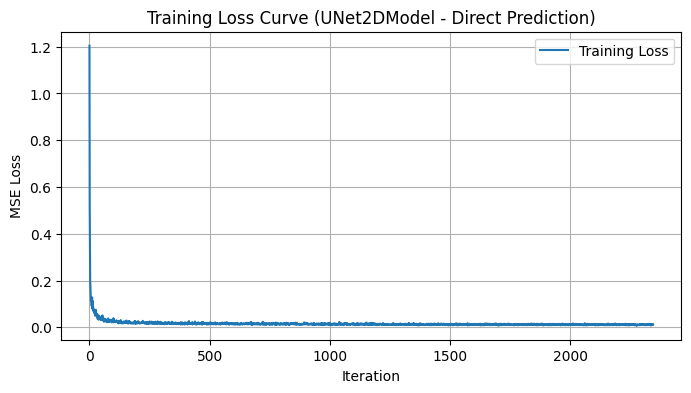

In [ ]:
# --- Plotting Loss Curve ---
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.title("Training Loss Curve (UNet2DModel - Noise Prediction)")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

By making these modifications, we've successfully shifted our training paradigm from direct image prediction to noise prediction, leveraging the `DDPMScheduler` to manage the diffusion process. In the next section, we'll focus on how to modify the inference process to generate images using scheduled denoising.

## Inference with Scheduled Denoising: Generating Images Iteratively

With our model now trained to predict noise, we can finally generate images using the true power of diffusion models: **iterative denoising guided by a schedule**.  This is a significant departure from our one-shot denoising approach in [Parts 1](https://hassaanbinaslam.github.io/posts/2025-02-10-diffusion-model-mnist-part1.html) and [2](https://hassaanbinaslam.github.io/posts/2025-02-15-diffusion-model-mnist-part2.html).

Here's how we'll modify the inference process.

**1.  Start with Pure Noise:**

   We begin the generation process with pure random noise. This noise will be our starting point for the reverse diffusion process.

   ```python
   sample = torch.randn((num_images, 1, image_size, image_size)).to(device)
   ```

**2.  Set up the Denoising Loop:**

   We'll use a loop that iterates through the **timesteps** provided by our `scheduler`.  Crucially, during inference, we need to use the *inference timesteps* which are obtained using `scheduler.set_timesteps(num_inference_steps)`.  These timesteps are in *descending order*, going from high noise to low noise.

   ```python
   for t in scheduler.timesteps:
       # ... denoising step ...
   ```

**3.  Model Predicts Noise at Each Timestep:**

   Inside the loop, for each timestep `t`, we feed the current noisy image `sample` and the timestep `t` to our `UNet2DModel` to predict the noise:

   ```python
   noise_pred = model(sample, t, return_dict=False)[0]
   ```

**4.  Scheduler Steps Backwards:**

   This is the core of scheduled denoising! We use the `scheduler.step` function to take a step *backwards* along the diffusion trajectory, removing a bit of noise from the current `sample`.  The `step` function takes the `noise_pred`, the current timestep `t`, and the current `sample` as input and returns a dictionary containing the updated sample in `prev_sample`.

   ```python
   output = scheduler.step(noise_pred, t, sample)
   sample = output.prev_sample
   ```

   The `scheduler.step` function intelligently uses the predicted noise and the schedule information to determine how much to "denoise" the image at each timestep.  This is where the magic of the diffusion schedule comes in!

**5.  Iterate and Refine:**

   We repeat steps 3 and 4 for all timesteps in the schedule.  In each iteration, the image becomes progressively less noisy and more structured, gradually revealing a coherent MNIST digit.

**6.  Visualization:**

   After the loop completes, the `sample` tensor will contain the generated (denoised) images.  We can then visualize these images as we did in previous parts.

**Complete Inference Loop Snippet:**

Here's the complete inference loop snippet from your code, demonstrating scheduled denoising:


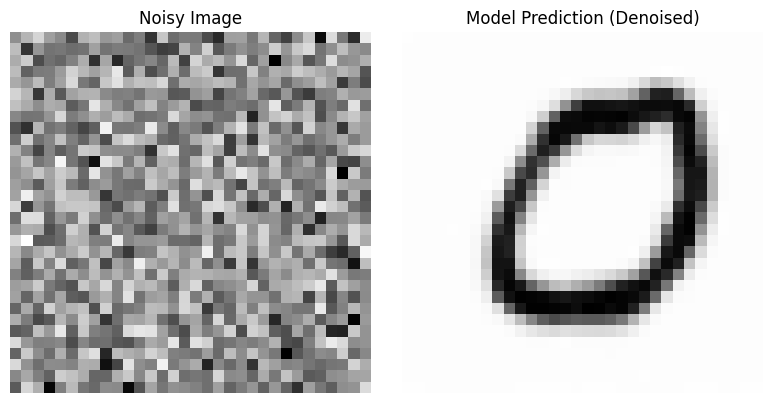

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

# Number of inference steps (can be the same as used before)
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps)

# Start with a single image of pure noise
noise_image = torch.randn((1, 1, image_size, image_size)).to(device)
sample = noise_image.clone()

with torch.no_grad():
    for t in scheduler.timesteps:
        # Predict the noise at the current timestep
        noise_pred = model(sample, t).sample
        # Use the scheduler to compute the previous (less noisy) sample
        output = scheduler.step(noise_pred, t, sample)
        sample = output.prev_sample

denoised_image = sample.clone()

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(noise_image.squeeze().cpu().numpy(), cmap="Greys")
axs[0].set_title("Noisy Image")
axs[0].axis("off")

axs[1].imshow(denoised_image.squeeze().cpu().numpy(), cmap="Greys")
axs[1].set_title("Model Prediction (Denoised)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


## Iterative Denoising with Varying Inference Steps

To visually explore the impact of scheduled denoising, let's now denoise a batch of MNIST test images using different numbers of inference steps. We'll use our `do_inference` function, varying `num_inference_steps` from 1 to 5. This will allow us to observe how the quality of the denoised digits improves as we increase the number of refinement steps.

**Inference with 1 Step:**

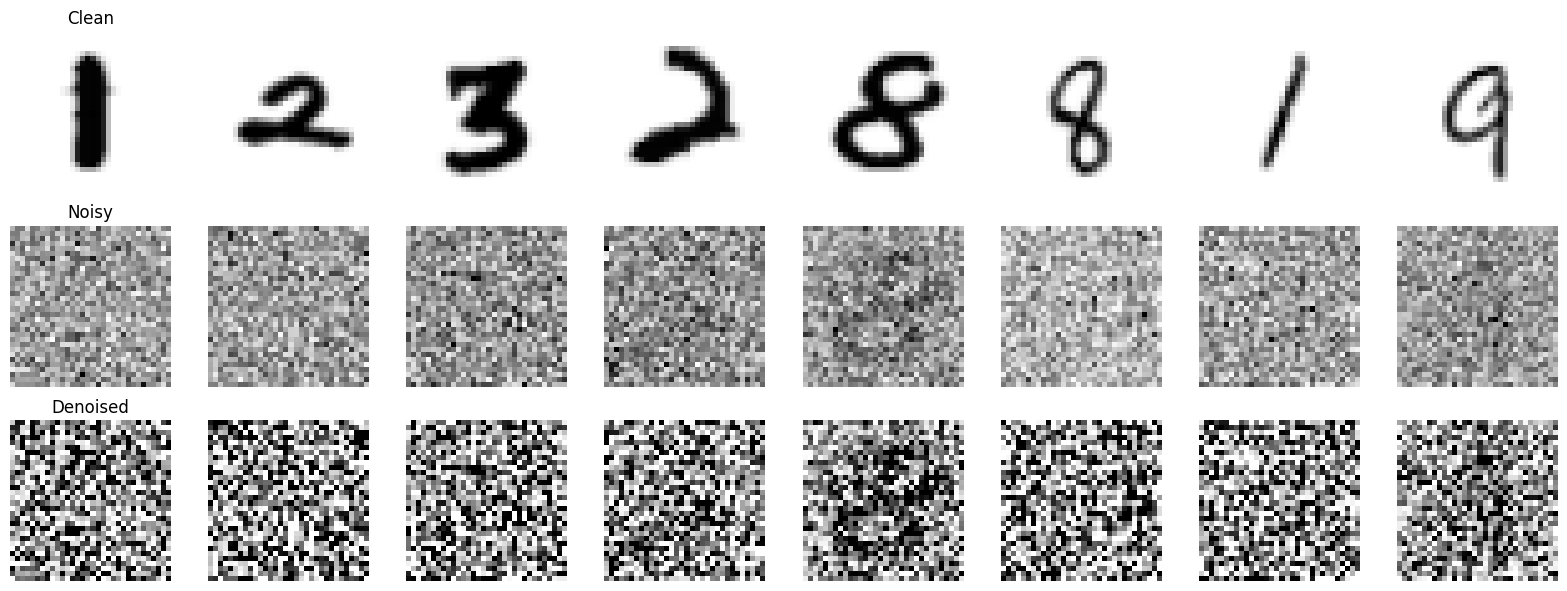

In [31]:
# multi step inference

import torch
import matplotlib.pyplot as plt

def do_inference(num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)

    # Make sure your model is in evaluation mode
    model.eval()

    # Create a dataloader for the test (or validation) split.
    # (If you don’t have a separate test split, you can use a subset of the training data.)
    batch_size=8
    test_dataloader = torch.utils.data.DataLoader(dataset["test"], batch_size, shuffle=True)

    # Grab one batch of images from the test set
    batch = next(iter(test_dataloader))
    clean_images = batch["images"].to(device)  # these are the ground-truth images

    # Sample random noise to add
    noise = torch.randn_like(clean_images).to(device)

    # Sample a random timestep for each image in the batch
    timesteps = torch.randint(0, num_train_timesteps, (batch_size,), device=device).long()

    # Add noise to the clean images according to the scheduler's forward process
    noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

    # Iteratively denoise the sample using the scheduler's timesteps
    denoised_images = noisy_images.clone()
    with torch.no_grad():
        for t in scheduler.timesteps:
            # The model expects the timestep (here, a scalar or tensor) as input.
            denoised_sample = model(denoised_images, t).sample
            # The scheduler returns a dict containing the updated sample in "prev_sample"
            output = scheduler.step(denoised_sample, t, denoised_images)
            denoised_images = output.prev_sample

    # Move tensors to CPU for plotting
    clean_images_np = clean_images.cpu().numpy()
    noisy_images_np = noisy_images.cpu().numpy()
    denoised_images_np = denoised_images.cpu().numpy()

    # Plot the results:
    # - Top row: Clean images (ground truth)
    # - Middle row: Noisy images (input to the model)
    # - Bottom row: Denoised images (model output)
    num_images = clean_images_np.shape[0]
    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 2, 6))
    for i in range(num_images):
        # Clean image
        axes[0, i].imshow(clean_images_np[i].squeeze(), cmap="Greys")
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Clean")

        # Noisy image
        axes[1, i].imshow(noisy_images_np[i].squeeze(), cmap="Greys")
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Noisy")

        # Denoised image (model output)
        axes[2, i].imshow(denoised_images_np[i].squeeze(), cmap="Greys")
        axes[2, i].axis("off")
        if i == 0:
            axes[2, i].set_title("Denoised")

    plt.tight_layout()
    plt.show()

# Set the number of inference steps and update the scheduler's timesteps accordingly.
num_inference_steps = 1
do_inference(num_inference_steps)

With just a single inference step, the "Denoised" row presents an *initial* attempt at noise removal. The digits are barely recognizable and remain heavily influenced by the original noise.

**Inference with 2 Steps:**

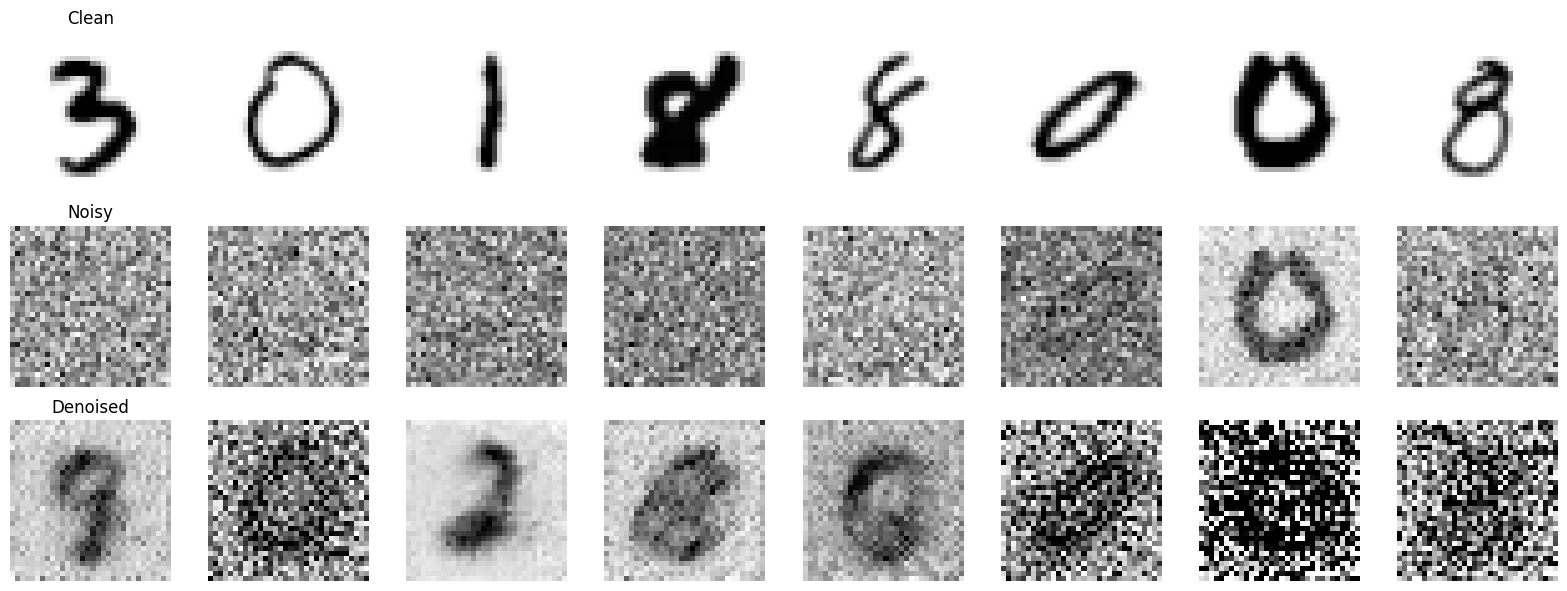

In [32]:
# Set the number of inference steps and update the scheduler's timesteps accordingly.
do_inference(num_inference_steps=2)

Increasing the inference steps to 2, we observe a noticeable improvement. The digits in the "Denoised" row are becoming more defined. The shapes are clearer, and we can start to discern the intended digits more confidently. However, there's still a considerable amount of blur and noise remaining, and fine details are lacking.

::: {.callout-note}

You might have noticed that the denoised images actually deviate from the original ones. For example, the first clean image is a 3, but the denoised version more closely resembles a 9. Similarly, the third clean image is a 1, yet its denoised version resembles a 2. Why does this happen?  

I'm not entirely sure. I've experimented with it and tried to identify the cause but haven't found a definitive answer. My theory is that the scheduler might be increasing the noise in the first step instead of reducing it. At this stage, the actual image signal could be getting lost in the added noise. As a result, when the second step attempts to remove the noise and recover the original image, it fails.

:::

**Inference with 3 Steps:**

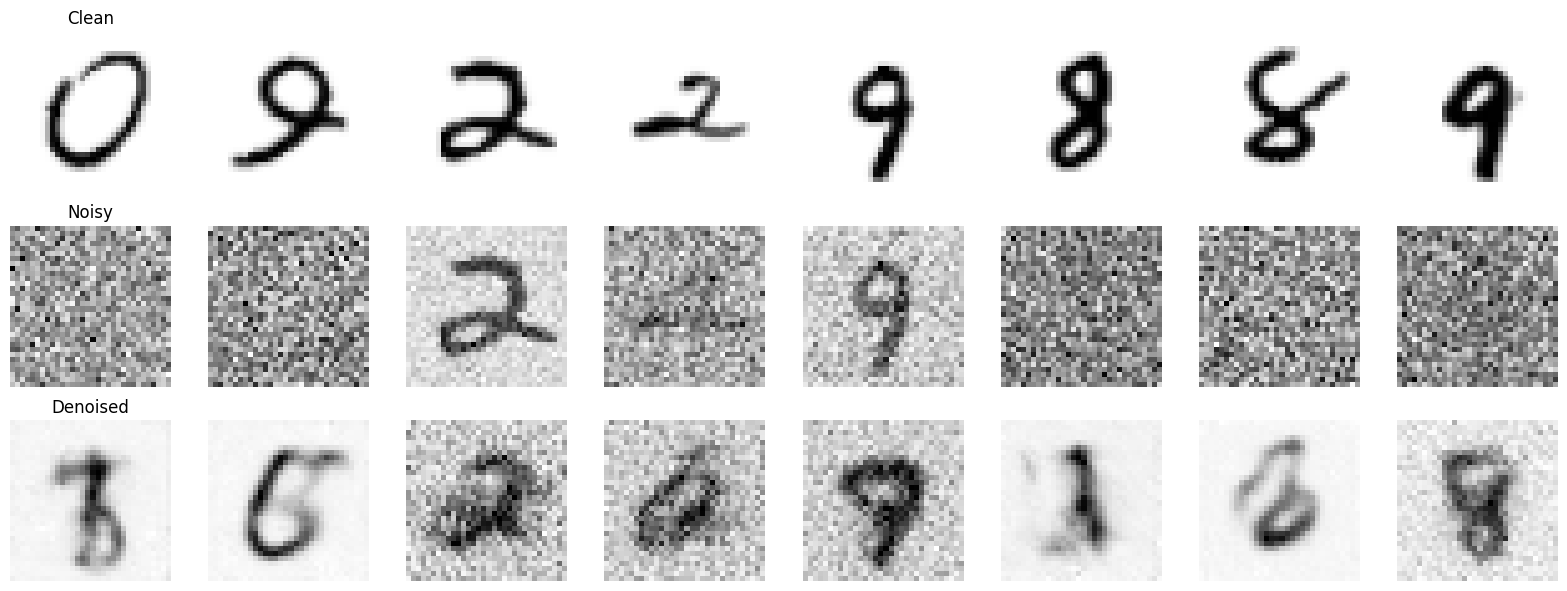

In [33]:
# Set the number of inference steps and update the scheduler's timesteps accordingly.
do_inference(num_inference_steps=3)

At 3 inference steps, the trend of improvement continues. The "Denoised" digits are now even more recognizable and sharper. The digits like '2', '8', and '9' are becoming quite distinct from the noisy input. The background noise is further reduced, allowing the digit structure to emerge more prominently.

**Inference with 4 Steps:**

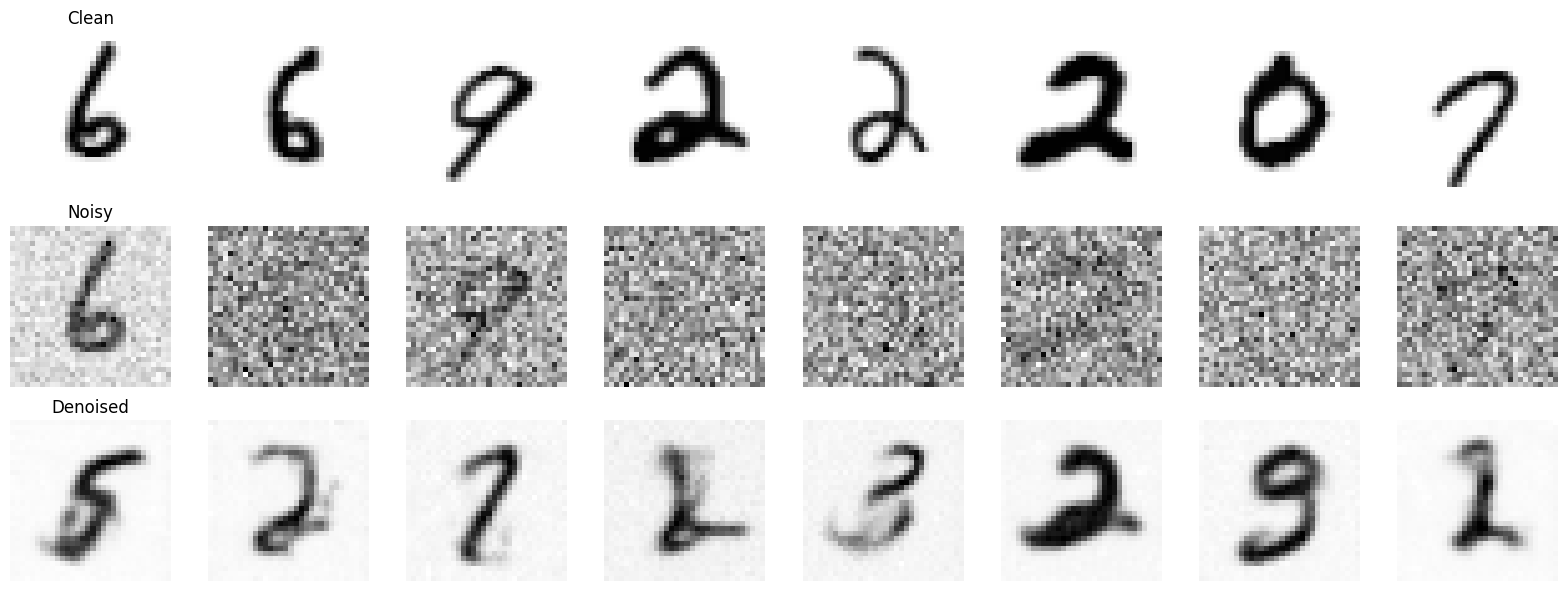

In [34]:
# Set the number of inference steps and update the scheduler's timesteps accordingly.
do_inference(num_inference_steps=4)

With 4 inference steps, the quality jumps again. The "Denoised" digits are now quite clear and well-formed.  The residual blur is further minimized, and the digits are gaining more crispness.

**Inference with 5 Steps:**

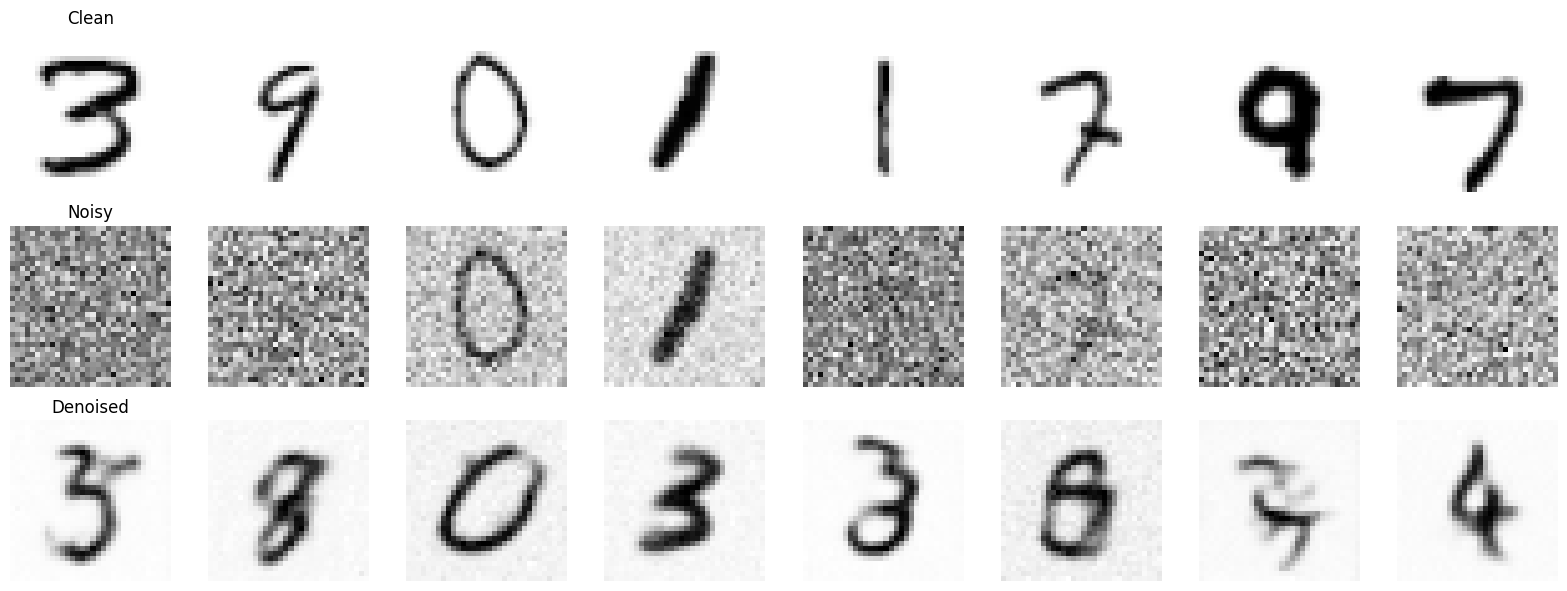

In [35]:
# Set the number of inference steps and update the scheduler's timesteps accordingly.
do_inference(num_inference_steps=5)

Finally, at 5 inference steps, we reach a point where the "Denoised" digits are quite impressive.  They exhibit a good level of sharpness and clarity.  While not perfectly identical to the originals, they are now convincingly denoised MNIST digits.  Comparing the "Denoised" row to the "Noisy" row clearly shows the effectiveness of the scheduled denoising process in removing the added noise and recovering the underlying digit structure.

**Observations and Trend:**

By visually comparing the results across 1 to 5 inference steps, we can clearly observe a positive correlation: **increasing the number of inference steps generally leads to improved denoising quality.**

**Inference with 50 Steps:**

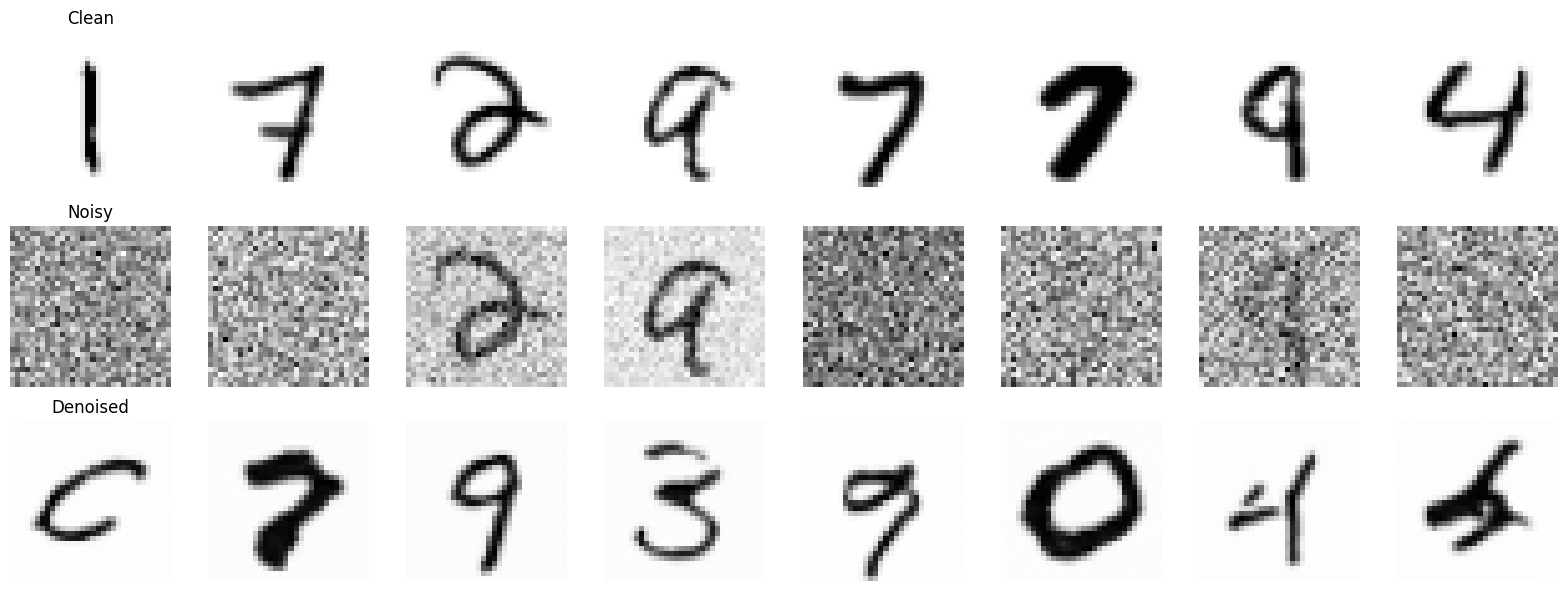

In [36]:
# Set the number of inference steps and update the scheduler's timesteps accordingly.
do_inference(num_inference_steps=50)

This experiment effectively demonstrates the power of iterative refinement in diffusion models. Scheduled denoising, even with a small number of steps, can significantly improve the quality of generated (or in this case, denoised) images.

## Iterative Refinement from Pure Noise

Now, let's push our enhanced `UNet2DModel` further and explore its ability to generate MNIST digits *directly from pure random noise* through iterative refinement.  This is a more generative task compared to the denoising experiments in the last section.  We'll start with a batch of pure noise and iteratively refine it over 5 steps, observing how digit-like structures emerge.

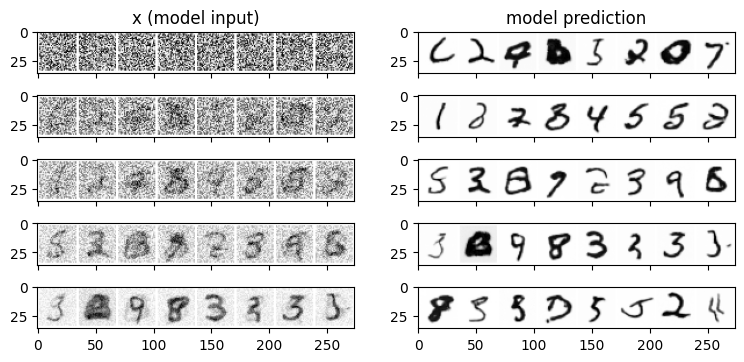

In [37]:
import torchvision
from matplotlib import pyplot as plt

n_steps = 5
x = torch.rand(8, 1, 32, 32).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []
model.to(device)

pred = x.clone()
for i in range(n_steps):
    # Predict denoise image
    with torch.no_grad():
        for t in scheduler.timesteps:
            sample = model(pred, t).sample
            output = scheduler.step(sample, t, pred)
            pred = output.prev_sample


    # Store output for plotting
    pred_output_history.append(pred.detach().cpu())

    # Move slightly towards that direction
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

    # Store output for plotting
    step_history.append(x.detach().cpu())

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys"
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1),
        cmap="Greys",
    )

The image above visualizes the iterative refinement process.  Let's examine each column:

*   **Left Column: "x (model input)" - Image at Each Refinement Step:** This column shows the evolving image at each step of the refinement process.  Starting from the top row with pure random noise, we can trace the gradual transformation over 5 steps.

*   **Right Column: "model prediction" - Model's Direct Prediction at Each Step:** This column displays the direct output of the `UNet2DModel` at each step.  It represents what the model *predicts* should be the next, less noisy image in the sequence.  Observing this column, we can see that the model consistently predicts images that are slightly less noisy and more digit-like than the current input image in the left column, guiding the refinement process.

## Long-Term Iterative Generation (50 Steps)

To fully appreciate the image generation capabilities of our diffusion model, let's extend the iterative refinement process to a larger number of steps. In this section, we'll generate MNIST digits from pure noise using `num_inference_steps = 50`. This extended denoising process should allow the model to refine the images more thoroughly, potentially leading to higher quality and more detailed digits.

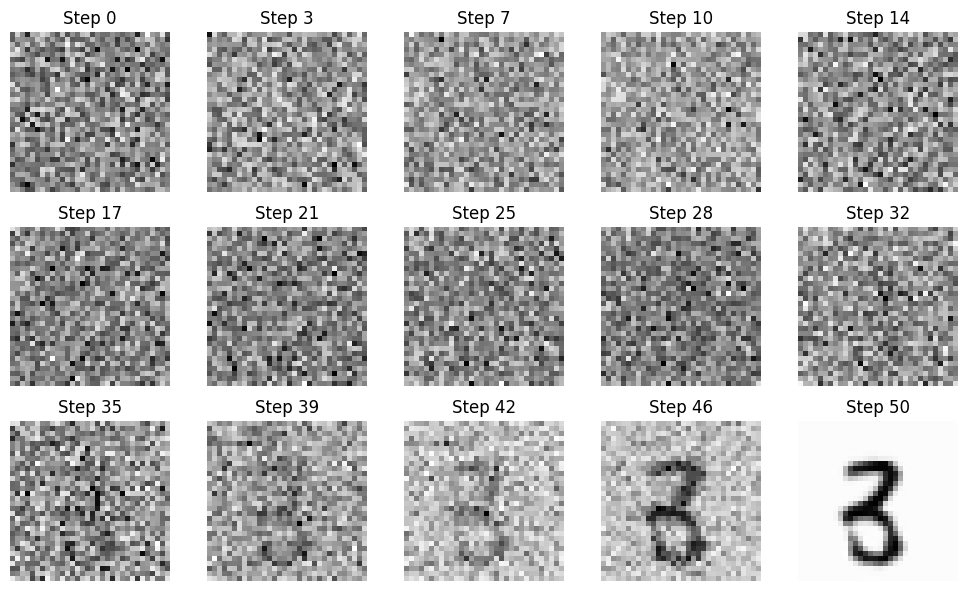

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()

# Number of inference steps
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps)

# Start with a single image of pure noise
sample = torch.randn((1, 1, image_size, image_size)).to(device)

# List to store intermediate images
progression = [sample.clone()]

with torch.no_grad():
    for t in scheduler.timesteps:
        # Predict noise and get the previous sample
        noise_pred = model(sample, t).sample
        output = scheduler.step(noise_pred, t, sample)
        sample = output.prev_sample
        progression.append(sample.clone())

# Convert tensors to NumPy arrays for plotting
progression = [img.squeeze().cpu().numpy() for img in progression]

# Select a subset to display
num_to_plot = 15  # Change this based on how many you want to display
indices = np.linspace(0, len(progression) - 1, num_to_plot, dtype=int)
selected_images = [progression[i] for i in indices]

# Set grid size
rows = 3  # Adjust based on your preference
cols = (num_to_plot + rows - 1) // rows  # Compute columns dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()  # Flatten in case it's a 2D grid

# Plot images
for idx, ax in enumerate(axes):
    if idx < num_to_plot:
        ax.imshow(selected_images[idx], cmap="Greys")
        ax.set_title(f"Step {indices[idx]}")
        ax.axis("off")
    else:
        ax.axis("off")  # Hide extra empty subplots

plt.tight_layout()
plt.show()


The image above visualizes the evolution of a generated MNIST digit over 15 selected steps from the 50-step denoising process. While we are only showing a subset of the steps for clarity, it represents the full 50-step refinement.

## Conclusion

In this three-part series, we embarked on a hands-on journey to demystify diffusion models and build our own MNIST digit generator from scratch.  Starting with a basic Convolutional UNet and direct image prediction, we progressively enhanced our model and delved deeper into the core principles of diffusion.

**Key Milestones of Our Journey:**

*   [**Part 1: Laying the Foundation:**](https://hassaanbinaslam.github.io/posts/2025-02-10-diffusion-model-mnist-part1.html) We built a simple `BasicUNet` and trained it for direct image prediction, establishing a baseline and understanding the fundamentals of UNet architectures for denoising tasks.
*   [**Part 2: Enhancing the Architecture:**](https://hassaanbinaslam.github.io/posts/2025-02-15-diffusion-model-mnist-part2.html) We upgraded to the `diffusers` library's `UNet2DModel`, incorporating ResNet blocks and attention mechanisms, and observed a noticeable improvement in denoising quality, showcasing the power of more sophisticated architectures.
*   **Part 3: Embracing True Diffusion:** In this final part, we made the crucial shift to **noise prediction** and **scheduled denoising**, leveraging the `DDPMScheduler`. We witnessed firsthand how these core concepts unlock the true potential of diffusion models, enabling us to generate high-quality MNIST digits from pure random noise through iterative refinement.


In Part 3, we moved beyond simplified approaches and successfully implemented key elements of modern diffusion models. We saw firsthand how a learned noise prediction model and a well-designed denoising schedule can transform pure noise into coherent, recognizable images. With more inference steps, image quality improved significantly.  

I hope this guide has helped you understand and experiment with diffusion models. The code and explanations provided serve as a strong foundation for further exploration. Now, go forth and create your own *diffusion model magic*!